In [1]:
from astro.load import Loader, GroupSessionData
from astro.preprocess import Preprocessor, GroupedEventPreprocessor
from astro.transforms import GroupSplitter


from trace_minder.preprocess import TracePreprocessor
from trace_minder.align import GroupedAligner
from trace_minder.surrogates import Rotater

import os
from pathlib import Path
from astro.config import Config

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

from copy import deepcopy
from tqdm import tqdm
from dataclasses import dataclass

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

#### Paths

In [2]:
notebook_path = Path(os.getcwd())
root_path = notebook_path.parent.parent
env_path = root_path / ".env"

paths = Config.from_env(env_path)

#### Config

- Configuration for loading, preprocessing and metadata.

In [3]:
loader = Loader(data_dir=paths.data_dir)

loader_preprocessor_first5 = Preprocessor(
    trace_preprocessor=TracePreprocessor(
        max_time=600,
        standardize=True,
        medfilt_kernel_size=None,
        resample_frequency=0.1,
        drop_na=True,
    ),
    grouped_event_preprocessor=GroupedEventPreprocessor(
        df_events_group_col="mouse_name",
        df_events_event_time_col="start_time",
        first_x_events=5,
    ),
)
loader.preprocessor = loader_preprocessor_first5


group_splitter = GroupSplitter(
    df_mice=loader.load_mice(),
    df_neurons=loader.load_neurons(),
    df_traces_time_col="time",
)

# aligner for clustering -> only post data
aligner_cluster = GroupedAligner(
    t_before=0,
    t_after=30,
    df_wide_group_mapper=group_splitter.neurons_by_mouse,
    df_events_event_time_col="start_time",
    df_events_group_col="mouse_name",
    round_precision=1,
)

# aligner for plotting -> -5 pre to 55 post
aligner_plot = GroupedAligner(
    t_before=5,
    t_after=55,
    df_wide_group_mapper=group_splitter.neurons_by_mouse,
    df_events_event_time_col="start_time",
    df_events_group_col="mouse_name",
    round_precision=1,
)

## Clustering

### Tooling

##### Results Accumulation

In [4]:
@dataclass
class ClusteringResults:
    session: str
    block_group: str
    group_used_for_clustering: str
    k_clusters: int
    df_elbow_obs: pd.DataFrame | None = None
    df_elbow_null: pd.DataFrame | None = None
    elbow_plot_obs: plt.Figure | None = None
    elbow_plot_null: plt.Figure | None = None
    cluster_map_dfs: dict[str, pd.DataFrame] | None = None
    average_trace_dfs: dict[str, pd.DataFrame] | None = None

##### Elbow Plot

In [5]:
class ElbowMaker:
    def __init__(
        self,
        aligner: GroupedAligner,
        min_k: int = 1,
        max_k: int = 20,
        scalter: StandardScaler | None = None,
        kmeans: KMeans | None = None,
    ):
        self.aligner = aligner
        self.min_k = min_k
        self.max_k = max_k
        self.cluster_range = np.arange(min_k, max_k + 1)

        self.scaler = StandardScaler() if scalter is None else scalter
        self.kmeans = KMeans(n_init="auto") if kmeans is None else kmeans

        self.error_ = np.empty(len(self.cluster_range))
        self.error_df_ = pd.DataFrame()

    def fit(self, group_data: GroupSessionData, block_group: str = "CS"):
        df_traces = group_data.df_traces
        df_events = group_data.df_block_starts(block_group=block_group)

        df_aligned = self.aligner.average_trace(df_traces, df_events)

        df_scaled = StandardScaler().fit_transform(df_aligned)

        for i, k in enumerate(self.cluster_range):
            kmeans = deepcopy(self.kmeans)
            kmeans.set_params(n_clusters=k)
            kmeans.fit(df_scaled)
            self.error_[i] = kmeans.inertia_

        self.error_df_ = pd.DataFrame({"k": self.cluster_range, "error": self.error_})

        return self.error_df_


class NullElbowMaker:
    def __init__(
        self,
        aligner: GroupedAligner,
        min_k: int = 1,
        max_k: int = 20,
        n_boot: int = 50,
        scaler: StandardScaler | None = None,
        kmeans: KMeans | None = None,
        rotater: Rotater | None = None,
    ):
        self.aligner = aligner
        self.min_k = min_k
        self.max_k = max_k
        self.cluster_range = np.arange(min_k, max_k + 1)
        self.n_boot = n_boot

        self.error_ = np.empty((n_boot, len(self.cluster_range)))
        self.error_df_ = pd.DataFrame()

        self.kmeans = KMeans(n_init="auto") if kmeans is None else kmeans
        self.rotater = (
            Rotater(time_col="time", copy=True) if rotater is None else rotater
        )
        self.scaler = StandardScaler() if scaler is None else scaler

    @classmethod
    def from_elbow_maker(
        cls, elbow_maker: ElbowMaker, rotater: Rotater | None = None, n_boot: int = 50
    ):
        return cls(
            aligner=elbow_maker.aligner,
            min_k=elbow_maker.min_k,
            max_k=elbow_maker.max_k,
            n_boot=n_boot,
            rotater=rotater,
        )

    def fit(self, group_data: GroupSessionData, block_group: str = "CS"):
        df_traces = group_data.df_traces
        df_events = group_data.df_block_starts(block_group=block_group)

        for i in tqdm(range(self.n_boot)):
            df_traces_boot = self.rotater(df_traces)
            df_traces = self.rotater(df_traces_boot)
            df_aligned = self.aligner.average_trace(df_traces, df_events)

            df_scaled = StandardScaler().fit_transform(df_aligned)

            for j, k in enumerate(self.cluster_range):
                kmeans = deepcopy(self.kmeans)
                kmeans.set_params(n_clusters=k)
                kmeans.fit(df_scaled)
                self.error_[i, j] = kmeans.inertia_

        self.error_df_ = (
            pd.DataFrame(self.error_, columns=self.cluster_range)
            .assign(boot_idx=np.arange(self.n_boot))
            .melt(id_vars="boot_idx", value_name="error", var_name="k")
            .sort_values(["boot_idx", "k"])
        )

        return self.error_df_

##### Elbow Plotting

In [6]:
def plot_elbow(
    n_clusters: np.ndarray,
    error: np.ndarray,
    figsize: tuple[int, int] = (6, 4),
):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(n_clusters, error, "-o", color="black")
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Error")
    ax.grid()
    return fig, ax


def plot_elbow_null(
    n_clusters: np.ndarray,
    error_tensor: np.ndarray,
    figsize: tuple[int, int] = (6, 4),
):
    mean_error = error_tensor.mean(axis=0)
    std_error = error_tensor.std(axis=0)

    f, ax = plt.subplots(figsize=figsize)
    ax.plot(n_clusters, mean_error, "-o", color="black")
    ax.fill_between(
        n_clusters,
        mean_error - std_error,
        mean_error + std_error,
        color="gray",
        alpha=0.5,
    )
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Error")
    ax.grid()
    return f, ax

##### Fitting and Predicitng Clusters Given K

In [7]:
def fit_cluster_pipe(
    group_session_data: GroupSessionData,
    pipeline: Pipeline,
    aligner: GroupedAligner,
    block_group: str = "CS",
):
    df_traces = group_session_data.df_traces
    df_events = group_session_data.df_block_starts(block_group=block_group)
    df_aligned = (
        aligner.average_trace(df_traces, df_events)
        .set_index(["aligned_time"])
        .transpose()
    )

    pipeline.fit(df_aligned.values)

    return pipeline


def get_clusters(
    group_session_data: GroupSessionData,
    pipeline: Pipeline,
    aligner: GroupedAligner,
    block_group: str = "CS",
):
    df_traces = group_session_data.df_traces
    df_events = group_session_data.df_block_starts(block_group=block_group)
    df_aligned = (
        aligner.average_trace(df_traces, df_events)
        .set_index(["aligned_time"])
        .transpose()
    )

    clusters = pipeline.predict(df_aligned.values)
    neurons = df_aligned.index.values
    df_cluster_map = pd.DataFrame({"cell_id": neurons, "cluster": clusters})
    return df_cluster_map

##### Visualizing Clusters: Average Traces by Cluster

In [8]:
def average_trace_ordered_by_cluster(
    group_session_data: GroupSessionData,
    df_cluster_mapper: pd.DataFrame,
    aligner: GroupedAligner,
    block_group: str = "CS",
) -> pd.DataFrame:
    idx = df_cluster_mapper.sort_values("cluster").cell_id.values.tolist()

    df_traces = group_session_data.df_traces
    df_events = group_session_data.df_block_starts(block_group=block_group)

    df_aligned = aligner.average_trace(df_traces, df_events)
    df_aligned = df_aligned.set_index("aligned_time").transpose()

    df_aligned = df_aligned.loc[idx]
    df_aligned.index.name = "cell_id"

    return df_aligned

## Data

100%|██████████| 30/30 [00:35<00:00,  1.19s/it]


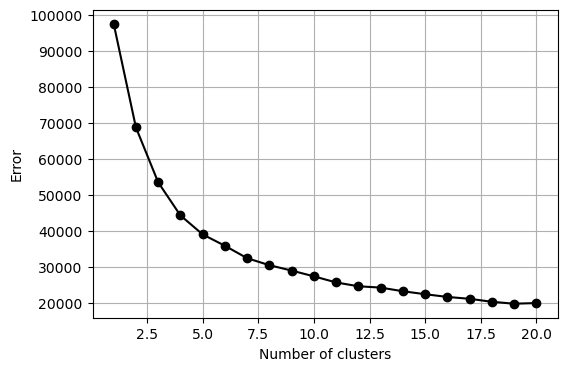

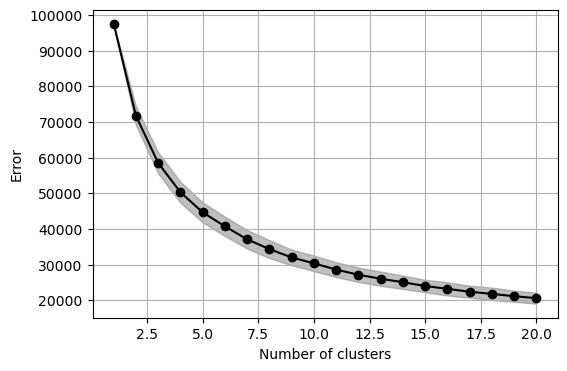

In [9]:
SESSION = "ret"
VEH_GROUP = (
    "VEH-CNO"  # group whose neurons will be used to generate the clustering model
)
CNO_GROUP = "CNO-VEH"
CLUSTERING_GROUP = VEH_GROUP
PREDICT_GROUP = CNO_GROUP if CLUSTERING_GROUP == VEH_GROUP else VEH_GROUP
BLOCK_GROUP = "CS"


RESULTS = ClusteringResults(
    session=SESSION,
    block_group=BLOCK_GROUP,
    group_used_for_clustering=CLUSTERING_GROUP,
    k_clusters=5,
)

group_session_data = GroupSessionData(
    loader=loader,
    group_splitter=group_splitter,
    session_name=SESSION,
    group=CLUSTERING_GROUP,
)

elbow_maker = ElbowMaker(aligner_cluster, min_k=1, max_k=20)
df_elbow_obs = elbow_maker.fit(group_session_data)


null_elbow_maker = NullElbowMaker.from_elbow_maker(elbow_maker, n_boot=30)
df_elbow_null = null_elbow_maker.fit(group_session_data)

f_obs, ax_obs = plot_elbow(elbow_maker.cluster_range, elbow_maker.error_)
f_null, ax_null = plot_elbow_null(
    null_elbow_maker.cluster_range, null_elbow_maker.error_, figsize=(6, 4)
)


RESULTS.df_elbow_obs = df_elbow_obs
RESULTS.df_elbow_null = df_elbow_null
RESULTS.elbow_plot_obs = f_obs
RESULTS.elbow_plot_null = f_null

### Generating Clusters

In [32]:
K = 5

clust_group_session_data = GroupSessionData(
    loader=loader,
    group_splitter=group_splitter,
    session_name=SESSION,
    group=CLUSTERING_GROUP,
)
pred_group_session_data = GroupSessionData(
    loader=loader,
    group_splitter=group_splitter,
    session_name=SESSION,
    group=PREDICT_GROUP,
)

cluster_pipeline = Pipeline(
    [
        ("standardize", StandardScaler()),
        (
            "km",
            KMeans(n_clusters=K, n_init="auto"),
        ),
    ]
)

cluster_pipeline = fit_cluster_pipe(
    clust_group_session_data, cluster_pipeline, aligner_cluster
)

clust_clusters = get_clusters(
    clust_group_session_data, cluster_pipeline, aligner_cluster
)
pred_clusters = get_clusters(pred_group_session_data, cluster_pipeline, aligner_cluster)

RESULTS.cluster_map_dfs = {
    PREDICT_GROUP: pred_clusters,
    CLUSTERING_GROUP: clust_clusters,
}

In [33]:
clust_average_traces = average_trace_ordered_by_cluster(
    clust_group_session_data, clust_clusters, aligner_plot
)
pred_average_traces = average_trace_ordered_by_cluster(
    pred_group_session_data, pred_clusters, aligner_plot
)

RESULTS.average_trace_dfs = {
    PREDICT_GROUP: pred_average_traces,
    CLUSTERING_GROUP: clust_average_traces,
}

In [34]:
OUTPUT_DIR = paths.derived_data_dir / "clustering"
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [38]:
from io import BytesIO


df_params = pd.Series(
    {
        "session": RESULTS.session,
        "block_group": RESULTS.block_group,
        "group_used_for_clustering": RESULTS.group_used_for_clustering,
        "k_clusters": RESULTS.k_clusters,
    },
    name="value",
)

with pd.ExcelWriter(OUTPUT_DIR / f"{SESSION}_clustering_results.xlsx") as writer:
    df_params.to_excel(writer, sheet_name="clustering_params")

    RESULTS.df_elbow_obs.to_excel(writer, sheet_name="elbow_obs")
    RESULTS.df_elbow_null.to_excel(writer, sheet_name="elbow_null")

    for group, df in RESULTS.cluster_map_dfs.items():
        df.to_excel(writer, sheet_name=f"{group}_cluster_map")

    for group, df in RESULTS.average_trace_dfs.items():
        df.to_excel(writer, sheet_name=f"{group}_average_traces")

    workbook = writer.book

    buffer_img_obs = BytesIO()
    RESULTS.elbow_plot_obs.savefig(buffer_img_obs, format="png", dpi=300)
    buffer_img_obs.seek(0)

    buffer_img_null = BytesIO()
    RESULTS.elbow_plot_null.savefig(buffer_img_null, format="png", dpi=300)
    buffer_img_null.seek(0)

    worksheet = writer.sheets["elbow_obs"]
    worksheet.insert_image("F2", "elbow_obs.png", {"image_data": buffer_img_obs})

    worksheet = writer.sheets["elbow_null"]
    worksheet.insert_image("F2", "elbow_null.png", {"image_data": buffer_img_null})